# Some Useful Links:

### Pytorch Broadcasting Semantics:
- https://pytorch.org/docs/stable/notes/broadcasting.html

### Installing Nividia GPU with Pytorch:
- https://www.youtube.com/watch?v=r7Am-ZGMef8


# Lecture5: Pytorch and Supervised Learning

## Main Learning Outcomes

- Understanding pytorch/numpy representation and manipulation of higher-dimensional data

- A mathematical primer to supervised learning

- Multi-layer preceptron linear algebra computation

- Pytorch Autograd

## Pytorch Tensors

- `storage` of tensors (ndarrays) is always linear and contigous.
- Broadcast: manipulating the stride of the argument tensors, so operations can be done. Example, for elementwise operations, it makes both arrays of equal size.

In [1]:
from matplotlib.pyplot import figure
from time import monotonic
from random import Random
from math import sqrt
import numpy as np

In [2]:
# Code Copied from previous lectures
SEED = 5
random_gen = Random(x = SEED)

def generate_points(N = 1000):
    lst_x, lst_y = [], []
    for _ in range(N):
        lst_x.append(random_gen.uniform(a = 0, b = 1))
    for _ in range(N):
        lst_y.append(random_gen.uniform(a = 0, b = 1))
    return lst_x, lst_y

In [3]:
def loss(x_p, y_p, batch_x, batch_y):
    return (1 / len(batch_x)) * sum([sqrt( (x_i - x_p)**2 + (y_i - y_p)**2)
                                      for x_i, y_i in zip(batch_x, batch_y)])

Time Taken: 46612.45087299999 ms


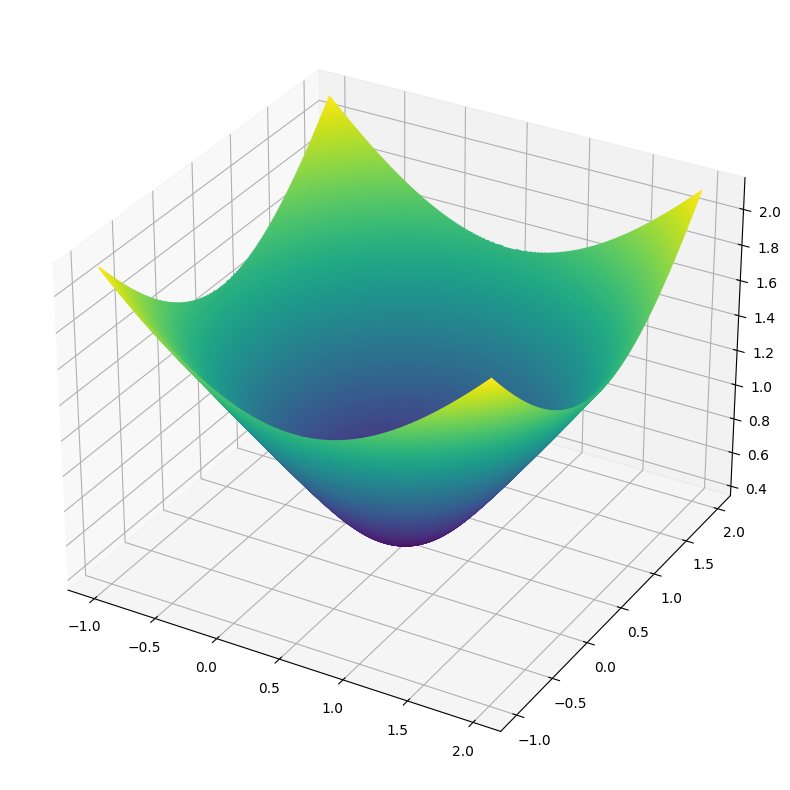

In [4]:
# Visualization
STEP = 0.01
MESH_SIZE = 300
data_x, data_y = generate_points()

x_mesh = [-1 + STEP * i for i in range(MESH_SIZE)]
y_mesh = [-1 + STEP * i for i in range(MESH_SIZE)]
start_time = monotonic()
loss_mesh = [ # List of Lists
              [loss(x_curr, y_curr, data_x, data_y) for x_curr in x_mesh]   # row by row
              for y_curr in y_mesh    # append list for each row
            ]
print(f'Time Taken: {(monotonic()-start_time)*1000} ms')

fig = figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.contour(x_mesh, y_mesh, loss_mesh, levels=500)
fig.show()

## Problems
- There was no direct way to manipulate higher dimensional data
- Storage doesn't allow efficient computations

## Solution
- Pytorch

In [5]:
import torch

data_torch = torch.tensor([data_x, data_y])
print(f"Shape Before Transpose: {data_torch.shape}")
print(f"Ptr to base address/data torch Before Transpose: {data_torch.storage().data_ptr()}")
print(f"Strides Before Transpose: Between Rows:{data_torch.stride(0)} , Between Columns: {data_torch.stride(1)}")

# Pytorch Separates Between The Storage & its View
data_torch = data_torch.t()
print(f"Shape After Transpose: {data_torch.shape}")
print(f"Ptr to base address/data torch After Transpose: {data_torch.storage().data_ptr()}")
print(f"Strides After Transpose: Between Rows:{data_torch.stride(0)} , Between Columns: {data_torch.stride(1)}")
#print(f"Storage: {data_torch.storage()}")


# Broadcasting (imagining your data in a much higher dimension)
data_torch = data_torch.broadcast_to(size=(100, 1000, 2))   # 3D Dimension(sort of copying of your data)
print(f"Shape After Broadcasting: {data_torch.shape}")
print(f"Strides After Broadcasting: Between lists:{data_torch.stride(0)} , Between Rows:{data_torch.stride(1)} , Between Columns: {data_torch.stride(2)}")

Shape Before Transpose: torch.Size([2, 1000])
Ptr to base address/data torch Before Transpose: 95259563261376
Strides Before Transpose: Between Rows:1000 , Between Columns: 1
Shape After Transpose: torch.Size([1000, 2])
Ptr to base address/data torch After Transpose: 95259563261376
Strides After Transpose: Between Rows:1 , Between Columns: 1000
Shape After Broadcasting: torch.Size([100, 1000, 2])
Strides After Broadcasting: Between lists:0 , Between Rows:1 , Between Columns: 1000


<ipython-input-5-68a9c1635b84>:5: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  print(f"Ptr to base address/data torch Before Transpose: {data_torch.storage().data_ptr()}")


In [6]:
data_torch = torch.tensor([data_x, data_y])
print(f"Shape Before Transpose: {data_torch.shape}")
data_torch = data_torch.t()
print(f"Shape After Transpose: {data_torch.shape}")

pnt = torch.tensor([5., 5.])
print(f"X_P & Y_P Shapes: {pnt.shape}")

res= data_torch-pnt
res= res**2
res = res.sum(dim=1)
res = torch.sqrt(res)
res = res.sum(dim=0)/data_torch.shape[0]
print(f"Result: {res}")
print(f"Result's Shape: {res.shape}")

Shape Before Transpose: torch.Size([2, 1000])
Shape After Transpose: torch.Size([1000, 2])
X_P & Y_P Shapes: torch.Size([2])
Result: 6.382888317108154
Result's Shape: torch.Size([])


In [ ]:
# More conservative syntax
# Functions in python are callable and also objects (can be stored in variables)
torch_loss_fn = lambda pnt, data : torch.sqrt(((data-pnt)**2).sum(dim=1)).sum(dim=0) / data.shape[0]
data_torch = torch.tensor([data_x, data_y]).t()

# Visualization
STEP = 0.01
MESH_SIZE = 300
data_x, data_y = generate_points()

x_mesh = [-1 + STEP * i for i in range(MESH_SIZE)]
y_mesh = [-1 + STEP * i for i in range(MESH_SIZE)]
start_time = monotonic()
loss_mesh = [  # List of Lists
              [torch_loss_fn(torch.tensor([x_curr, y_curr]) , data_torch) for x_curr in x_mesh]   # row by row
              for y_curr in y_mesh    # append list for each row
            ]
print(f'Time Taken: {(monotonic()-start_time)*1000} ms')

Time Taken: 4296.087630000329 ms


In [ ]:
# Further Speed comparison (removing the for loops) (Vectorization)
# By Assuming that the function takes a set of points not just one
torch_loss_fn_faster = lambda pnts, data : torch.sqrt(((pnt -\
                                                       data.repeat(( pnt.shape[0], 1, 1)).view(-1, pnt.shape[0], 2))\
                                                      **2).\
                                                       sum(dim=-1)).sum(dim=0) / data.shape[0]
data_torch = torch.tensor([data_x, data_y]).t()
x_0 = torch.linspace(-1, 2, 300).repeat(1, 300).t()
x_1 = torch.linspace(-1, 2, 300).repeat(300, 1).t().reshape(-1, 1)
pnts = torch.hstack((x_0, x_1))
res = torch_loss_fn_faster(pnts, data_torch)
print(f'Time Taken: {(monotonic()-start_time)*1000} ms')

Time Taken: 4322.928192999825 ms


In [ ]:
# # Further Speed comparison (Moving to device)
# # By Assuming that the function takes a set of points not just one
# torch_loss_fn_faster = lambda pnts, data : torch.sqrt(((pnt -\
#                                                        data.repeat(( pnt.shape[0], 1, 1)).view(-1, pnt.shape[0], 2))\
#                                                       **2).\
#                                                        sum(dim=-1)).sum(dim=0) / data.shape[0]

# data_torch = torch.tensor([data_x, data_y]).t().to('cuda:0')  # Move to Nividia GPU
# x_0 = torch.linspace(-1, 2, 300).repeat(1, 300).t()
# x_1 = torch.linspace(-1, 2, 300).repeat(300, 1).t().reshape(-1, 1)
# pnts = torch.hstack((x_0, x_1))
# res = torch_loss_fn_faster(pnts, data_torch)
# print(f'Time Taken: {(monotonic()-start_time)*1000} ms')

In [14]:
y= torch.randn(1000, 2)
y

tensor([[ 0.8644, -2.1327],
        [ 1.8067, -0.7068],
        [ 0.5862, -0.9806],
        ...,
        [ 0.0283,  0.6752],
        [ 1.6926,  1.5345],
        [-0.6587, -0.2009]])

In [24]:
print(y.shape)
print(y.stride())

torch.Size([1000, 2])
(2, 1)


In [26]:
data_torch = torch.tensor([data_x, data_y])
print(f"Shape Before Transpose: {data_torch.shape}")
print(data_torch.stride())


# Pytorch Separates Between The Storage & its View
data_torch = data_torch.t()
print(data_torch)
print(f"Shape After Transpose: {data_torch.shape}")
print(data_torch.stride())

Shape Before Transpose: torch.Size([2, 1000])
(1000, 1)
tensor([[0.6229, 0.8713],
        [0.7418, 0.0398],
        [0.7952, 0.5889],
        ...,
        [0.0433, 0.5908],
        [0.8241, 0.1494],
        [0.4944, 0.2024]])
Shape After Transpose: torch.Size([1000, 2])
(1, 1000)
